In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

## Generate meta-training and meta-testing data

In [2]:
from experiments.data_sim import SinusoidDataset

random_state = np.random.RandomState(26)
task_environment = SinusoidDataset(random_state=random_state)

meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)

# data for visualization
x_plot = np.linspace(-5, 5, num=150)
x_context, y_context, x_test, y_test = meta_test_data[0]

## Standard GP as a basline

[2020-02-11 09:49:34,126 -INFO]  Iter 1/1000 - Loss: 1.436 - Time 0.004 sec - Valid-LL: -1.315 - Valid-RMSE: 1.402 - Calib-Err 0.290
[2020-02-11 09:49:35,642 -INFO]  Iter 500/1000 - Loss: 1.436 - Time 1.516 sec - Valid-LL: -1.309 - Valid-RMSE: 1.405 - Calib-Err 0.296
[2020-02-11 09:49:37,305 -INFO]  Iter 1000/1000 - Loss: 1.436 - Time 1.664 sec - Valid-LL: -1.309 - Valid-RMSE: 1.405 - Calib-Err 0.296


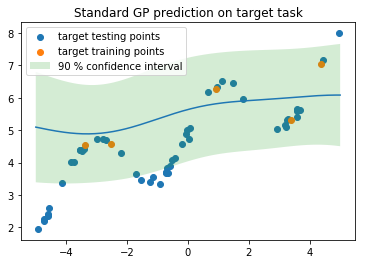

In [3]:
from meta_learn import GPRegressionLearned

gp = GPRegressionLearned(x_context, y_context, learning_mode='learn_mean', 
                         covar_module='SE', mean_module='constant', random_seed=30)
gp.fit(x_test, y_test)

# plot predictions
pred_mean, pred_std = gp.predict(x_plot)
ucb, lcb = gp.confidence_intervals(x_plot, confidence=0.9)

plt.scatter(x_test, y_test, label='target testing points' )
plt.scatter(x_context, y_context, label='target training points')

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2, label='90 % confidence interval')
plt.legend()
plt.title("Standard GP prediction on target task")
plt.show()


## Meta-Training with PACOH-MAP

In [4]:
from meta_learn import GPRegressionMetaLearned

meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2, num_iter_fit=12000, random_seed=30)
meta_gp.meta_fit(meta_test_data, log_period=1000)

[2020-02-11 09:49:37,635 -INFO]  Iter 1/12000 - Loss: 5.755850 - Time 0.02 sec - Valid-LL: -1.559 - Valid-RMSE: 1.284 - Calib-Err 0.138
[2020-02-11 09:50:04,270 -INFO]  Iter 1000/12000 - Loss: 4.953671 - Time 26.63 sec - Valid-LL: -1.198 - Valid-RMSE: 0.849 - Calib-Err 0.125
[2020-02-11 09:50:33,825 -INFO]  Iter 2000/12000 - Loss: 3.324356 - Time 29.34 sec - Valid-LL: -0.725 - Valid-RMSE: 0.514 - Calib-Err 0.138
[2020-02-11 09:51:05,749 -INFO]  Iter 3000/12000 - Loss: 1.704049 - Time 31.66 sec - Valid-LL: -0.464 - Valid-RMSE: 0.420 - Calib-Err 0.137
[2020-02-11 09:51:38,378 -INFO]  Iter 4000/12000 - Loss: 1.019263 - Time 32.42 sec - Valid-LL: -0.321 - Valid-RMSE: 0.419 - Calib-Err 0.126
[2020-02-11 09:52:06,258 -INFO]  Iter 5000/12000 - Loss: 0.663038 - Time 27.77 sec - Valid-LL: -0.208 - Valid-RMSE: 0.366 - Calib-Err 0.127
[2020-02-11 09:52:41,707 -INFO]  Iter 6000/12000 - Loss: 0.437905 - Time 35.19 sec - Valid-LL: -0.121 - Valid-RMSE: 0.363 - Calib-Err 0.121
[2020-02-11 09:53:22,149

0.2642439007759094

## Meta-Testing with PACOH-MAP

In [5]:
ll, rmse, calib_err = meta_gp.eval_datasets(meta_test_data)
print('Test log-likelihood:', ll)
print('Test RMSE:', rmse)
print('Test calibration error:', calib_err)

Test log-likelihood: 0.03293633884750306
Test RMSE: 0.3090165838599205
Test calibration error: 0.13442028164863587


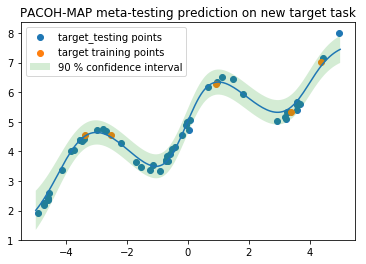

In [6]:
pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_plot)
ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_plot, confidence=0.9)

plt.scatter(x_test, y_test, label='target_testing points' )
plt.scatter(x_context, y_context, label='target training points')

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2, label='90 % confidence interval')
plt.legend()
plt.title("PACOH-MAP meta-testing prediction on new target task")
plt.show()

In [8]:
""" A) generate meta-training and meta-testing data """
from experiments.data_sim import SinusoidDataset
task_environment = SinusoidDataset()
meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)


""" B) Meta-Learning with PACOH-MAP """
from meta_learn import GPRegressionMetaLearned
meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2)
meta_gp.meta_fit(meta_test_data, log_period=1000)


"""  C) Meta-Testing with PACOH-MAP """
x_context, y_context, x_test, y_test = meta_test_data[0]

# target training in (x_ontext, y_context) & predictions for x_test
pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_test)

# confidence intervals predictions in x_test 
ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_test, confidence=0.9)

# compute evaluation metrics on one target task
log_likelihood, rmse, calib_error = meta_gp.eval(x_context, y_context, x_test, y_test)

# compute evaluation metrics for multiple tasks / test datasets
log_likelihood, rmse, calib_error = meta_gp.eval_datasets(meta_test_data)

[2020-02-11 10:05:32,241 -INFO]  Iter 1/10000 - Loss: 6.730902 - Time 0.02 sec - Valid-LL: -1.779 - Valid-RMSE: 1.684 - Calib-Err 0.118
[2020-02-11 10:05:52,925 -INFO]  Iter 1000/10000 - Loss: 4.964087 - Time 20.64 sec - Valid-LL: -1.245 - Valid-RMSE: 0.738 - Calib-Err 0.115
[2020-02-11 10:06:17,925 -INFO]  Iter 2000/10000 - Loss: 3.998452 - Time 24.75 sec - Valid-LL: -0.967 - Valid-RMSE: 0.643 - Calib-Err 0.110
[2020-02-11 10:06:43,047 -INFO]  Iter 3000/10000 - Loss: 3.438988 - Time 25.04 sec - Valid-LL: -0.775 - Valid-RMSE: 0.582 - Calib-Err 0.110
[2020-02-11 10:07:09,144 -INFO]  Iter 4000/10000 - Loss: 3.012415 - Time 25.85 sec - Valid-LL: -0.651 - Valid-RMSE: 0.578 - Calib-Err 0.111
[2020-02-11 10:07:43,892 -INFO]  Iter 5000/10000 - Loss: 2.647224 - Time 34.51 sec - Valid-LL: -0.456 - Valid-RMSE: 0.507 - Calib-Err 0.108
[2020-02-11 10:08:15,768 -INFO]  Iter 6000/10000 - Loss: 2.318684 - Time 31.61 sec - Valid-LL: -0.345 - Valid-RMSE: 0.481 - Calib-Err 0.112
[2020-02-11 10:08:49,379